In [1]:
import csv
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.optimize import root, fsolve
from scipy.special import binom
import pandas as pd
import time

In [2]:
# Initial data
p_a = 1
Nr = N = 3
nodes = 50
T_max = 12

T_idle = 3
T_bo = 3
T_rts = 3
T_cts = 3
T_data = 3
T_ack = 3
T_unit = 3
T_out = 3  # length of 1 tact in OUT
T_wait = 3  # length of 1 tact in WAIT

data_n = 1  # number of tacts in DATA

In [3]:
def csma_E_tc(p, p_f):
    # those conditions are here to avoid 'division by zero' error 
    if p_f == 1.:
        p_f = 0.9999999
    elif p_f == 0.:
        p_f = 0.0000001
    total_sum = 0
    for i in range(1, Nr + 1 + 1):
        wait_bo_addition = (data_n + 1) * T_wait + T_bo / (1 - p_f)
        out_addition = p * T_out * (1 - p_f ** (data_n + 1)) / (p_f ** (data_n + 1) * (1 - p_f))
        numerator = (p_f ** (2**i * T_max + 1) - 2**i * T_max * p_f - p_f + 2**i * T_max)
        denominator = (p_f - p_f ** (2**i * T_max + 1))
        cts_data_ack_addition = (1 - p) * (T_cts + data_n * T_data + T_ack)
        huge_sum = T_rts + out_addition + wait_bo_addition * numerator / denominator + cts_data_ack_addition
        total_sum += p ** (i - 1) * huge_sum
    return T_idle + p_a * total_sum

In [5]:
csma_E_tc(0.16529306460250853, 0.9304819212846616)

108.12181878495225

In [8]:
def csma_pi_idle(p, p_f):
    return T_idle / csma_E_tc(p, p_f)

def csma_pi_rts(p, p_f):
    total_sum = 0
    for i in range(1, Nr + 1 + 1): 
        numerator = p ** (i - 1) * p_a * T_rts
        denominator = csma_E_tc(p, p_f)
        total_sum += numerator / denominator
    return total_sum

def csma_pi_out(p, p_f):
    total_sum = 0
    for i in range(1, Nr + 1 + 1): 
        numerator = p ** (i - 1) * p_a * p * T_out * (1 - p_f ** (data_n + 1)) / (p_f ** (data_n + 1) * (1 - p_f))
        denominator = csma_E_tc(p, p_f)
        total_sum += numerator / denominator
    return total_sum

def csma_pi_cts(p, p_f):
    total_sum = 0
    for i in range(1, Nr + 1 + 1): 
        numerator = (1 - p) * p ** (i - 1) * p_a * T_cts
        denominator = csma_E_tc(p, p_f)
        total_sum += numerator / denominator
    return total_sum

def csma_pi_bo(p, p_f):
    if p_f == 1.:
        p_f = 0.9999999
    total_sum = 0
    for i in range(1, Nr + 1 + 1): 
        numerator = p ** (i - 1) * p_a * T_bo * (p_f ** (2**i * T_max + 1) - 2**i * T_max * p_f - p_f + 2**i * T_max)
        denominator = csma_E_tc(p, p_f) * (1 - p_f) * (p_f - p_f ** (2**i * T_max + 1))
        total_sum += numerator / denominator
    return total_sum

def csma_pi_wait(p, p_f):
    if p_f == 1.:
        p_f = 0.9999999
    total_sum = 0
    for i in range(1, Nr + 1 + 1): 
        numerator = p ** (i - 1) * p_a * (data_n + 1) * T_wait * (p_f ** (2**i * T_max + 1) - 2**i * T_max * p_f - p_f + 2**i * T_max)
        denominator = csma_E_tc(p, p_f) * (p_f - p_f ** (2**i * T_max + 1))
        total_sum += numerator / denominator
    return total_sum

def csma_pi_data(p, p_f):
    total_sum = 0
    for i in range(1, Nr + 1 + 1): 
        numerator = (1 - p) * p ** (i - 1) * p_a * data_n * T_data
        denominator = csma_E_tc(p, p_f)
        total_sum += numerator / denominator
    return total_sum

def csma_pi_ack(p, p_f):
    total_sum = 0
    for i in range(1, Nr + 1 + 1): 
        numerator = (1 - p) * p ** (i - 1) * p_a * T_ack
        denominator = csma_E_tc(p, p_f)
        total_sum += numerator / denominator
    return total_sum

In [9]:
def csma_p_success(p):
    total_sum = 0
    for i in range(1, Nr + 1 + 1):
        total_sum += (1 - p) * p ** (i - 1) * p_a
    return total_sum

# alternative formula
def csma_p_success(p):
    return 1 - p ** (Nr + 1)

def csma_p_failure(p):
    return p ** (Nr + 1)

In [10]:
# Проверка условия нормировки: для любых p и pf сумма всех pi_state должна быть равна 1

test_p = 0.478
test_pf = 0.3454353
print(
    csma_pi_idle(test_p, test_pf) + csma_pi_bo(test_p, test_pf) + csma_pi_rts(test_p, test_pf) + \
    csma_pi_out(test_p, test_pf) + csma_pi_cts(test_p, test_pf) + csma_pi_wait(test_p, test_pf) + \
    csma_pi_data(test_p, test_pf) + csma_pi_ack(test_p, test_pf)
)

1.0


In [11]:
sim_stats = {
    'nodes': 3, 
    'p_coll_node': 0.16252480288468418, 
    'p_coll_channel': 0.011732333333333334, 
    'p_failure': 0.0006980406739523617, 
    'p_success': 0.9993019593260476, 
    'p_free_node': 0.9303605573828384, 
    'p_busy_node': 0.06963944261716173, 
    'p_free_channel': 35.358236355555555, 
    'p_busy_channel': 2.6456510000000004, 
    'E_T_cycle': 108.9086266966803, 
    'E_T_idle': 3.0, 
    'E_T_bo': 80.75718060012201, 
    'E_T_rts': 3.5796776057377246, 
    'E_T_cts': 2.997905877978144, 
    'E_T_data': 2.997905877978144, 
    'E_T_ack': 2.997905877978144, 
    'E_T_out': 1.1962608030424868, 
    'E_T_wait': 11.381790053843622, 
    'pi_idle': 0.02754602726150659, 
    'pi_bo': 0.7415131661244574, 
    'pi_rts': 0.032868632305018665, 
    'pi_cts': 0.027526799014072265, 
    'pi_data': 0.027526799014072265, 
    'pi_ack': 0.027526799014072265, 
    'pi_out': 0.010984077564160036, 
    'pi_wait': 0.10450769970264032, 
    'B-R-R': 0.0012836, 
    'R-B-R': 0.0012825333333333334, 
    'R-R-B': 0.001289733333333333, 
    'R-R-R': 7.193333333333334e-05, 
    'R-R-C': 7.473333333333334e-05, 
    'R-C-R': 7.766666666666667e-05, 
    'C-R-R': 7.486666666666668e-05, 
    'B-R-C': 0.0012479333333333335, 
    'B-C-R': 0.0012493333333333332, 
    'R-B-C': 0.0012436, 
    'R-C-B': 0.0012427999999999999, 
    'C-R-B': 0.001254533333333333, 
    'C-B-R': 0.0012676666666666663
}


In [12]:
sim_p = sim_stats['p_coll_node']
sim_pf = sim_stats['p_free_node']
print(sim_p, sim_pf)
s1, a1 = sim_stats['E_T_cycle'], csma_E_tc(sim_p, sim_pf) 
s2, a2 = sim_stats['pi_idle'], csma_pi_idle(sim_p, sim_pf)
s3, a3 = sim_stats['pi_bo'], csma_pi_bo(sim_p, sim_pf)  
s4, a4 = sim_stats['pi_rts'], csma_pi_rts(sim_p, sim_pf) 
s5, a5 = sim_stats['pi_cts'], csma_pi_cts(sim_p, sim_pf) 
s6, a6 = sim_stats['pi_data'], csma_pi_data(sim_p, sim_pf)
s7, a7 = sim_stats['pi_ack'], csma_pi_ack(sim_p, sim_pf) 
s8, a8 = sim_stats['pi_out'], csma_pi_out(sim_p, sim_pf) 
s9, a9 = sim_stats['pi_wait'], csma_pi_wait(sim_p, sim_pf)
print(f"Etc:    \t{s1}\t{a1}\t{np.fabs(s1 - a1) / s1}")
print(f"pi idle:\t{s2}\t{a2}\t{np.fabs(s2 - a2) / s2}")
print(f"pi bo:  \t{s3}\t{a3}\t{np.fabs(s3 - a3) / s3}")
print(f"pi rts: \t{s4}\t{a4}\t{np.fabs(s4 - a4) / s4}")
print(f"pi cts: \t{s5}\t{a5}\t{np.fabs(s5 - a5) / s5}")
print(f"pi data:\t{s6}\t{a6}\t{np.fabs(s6 - a6) / s6}")
print(f"pi ack: \t{s7}\t{a7}\t{np.fabs(s7 - a7) / s7}")
print(f"pi out: \t{s8}\t{a8}\t{np.fabs(s8 - a8) / s8}")
print(f"pi wait:\t{s9}\t{a9}\t{np.fabs(s9 - a9) / s9}")

0.16252480288468418 0.9303605573828384
Etc:    	108.9086266966803	107.35727848830095	0.014244493346702344
pi idle:	0.02754602726150659	0.027944076472904623	0.014450330990352084
pi bo:  	0.7415131661244574	0.7398125009207298	0.002293506415558556
pi rts: 	0.032868632305018665	0.0333437689186353	0.014455624718649755
pi cts: 	0.027526799014072265	0.02792457944770164	0.014450660733419178
pi data:	0.027526799014072265	0.02792457944770164	0.014450660733419178
pi ack: 	0.027526799014072265	0.02792457944770164	0.014450660733419178
pi out: 	0.010984077564160036	0.012085654933969204	0.10028856436734437
pi wait:	0.10450769970264032	0.10304026041065598	0.014041446670051111


In [14]:
# FUNCTIONS FOR SPECIFIC NUMBERS OF NODE ONLY
tn = 3  # test nodes number

def test_p_collision(p, p_f):
    p_idle = csma_pi_idle(p, p_f)
    p_bo = csma_pi_bo(p, p_f)
    p_rts = csma_pi_rts(p, p_f)
    p_cts = csma_pi_cts(p, p_f)
    p_out = csma_pi_out(p, p_f)
    p_brr = p_bo * (p_rts / (p_idle + p_bo + p_rts + p_cts + p_out)) * (p_rts / (p_bo + p_rts + p_cts))
    p_brc = p_bo * (p_rts / (p_idle + p_bo + p_rts + p_cts + p_out)) * (p_cts / (p_bo + p_rts + p_cts))
    p_bcr = p_bo * (p_cts / (p_idle + p_bo + p_rts + p_cts + p_out)) * (p_rts / (p_bo + p_rts))
    p_rbr = p_rts * (p_bo / (p_bo + p_rts + p_cts + p_out)) * (p_rts / (p_bo + p_rts + p_cts))
    p_rbc = p_rts * (p_bo / (p_bo + p_rts + p_cts + p_out)) * (p_cts / (p_bo + p_rts + p_cts))
    p_rrb = p_rts * (p_rts / (p_bo + p_rts + p_cts + p_out)) * (p_bo / (p_bo + p_rts + p_cts))
    p_rrr = p_rts * (p_rts / (p_bo + p_rts + p_cts + p_out)) * (p_rts / (p_bo + p_rts + p_cts))
    p_rrc = p_rts * (p_rts / (p_bo + p_rts + p_cts + p_out)) * (p_cts / (p_bo + p_rts + p_cts))
    p_rcb = p_rts * (p_cts / (p_bo + p_rts + p_cts + p_out)) * (p_bo / (p_bo + p_rts))
    p_rcr = p_rts * (p_cts / (p_bo + p_rts + p_cts + p_out)) * (p_rts / (p_bo + p_rts))
    p_cbr = p_cts * (p_bo / (p_bo + p_rts + p_out)) * (p_rts / (p_bo + p_rts))
    p_crb = p_cts * (p_rts / (p_bo + p_rts + p_out)) * (p_bo / (p_bo + p_rts))
    p_crr = p_cts * (p_rts / (p_bo + p_rts + p_out)) * (p_rts / (p_bo + p_rts))
    
    p_coll_comb = p_rbr + p_rrb + p_rbc + p_rrr + p_rrc + p_rcb + p_rcr + p_brr + p_brc + p_bcr + p_cbr + p_crb + p_crr
#     return (p_rbr + p_rbc + p_rrb + p_rrr + p_rrc + p_rcb + p_rcr)
    return p_coll_comb


def test_p_free(p, p_f):
    p_idle = csma_pi_idle(p, p_f)
    p_bo = csma_pi_bo(p, p_f)
    p_rts = csma_pi_rts(p, p_f)
    p_cts = csma_pi_cts(p, p_f)
    p_data = csma_pi_data(p, p_f)
    p_ack = csma_pi_ack(p, p_f)
    p_out = csma_pi_out(p, p_f)
    p_wait = csma_pi_wait(p, p_f)
    
    p_ooc = p_out * (p_out / (p_bo + p_rts + p_cts + p_data + p_ack + p_out + p_wait)) * (p_cts / (p_bo + p_rts + p_cts + p_data + p_ack + p_out))
    p_oco = p_out * (p_cts / (p_bo + p_rts + p_cts + p_data + p_ack + p_out + p_wait)) * (p_out / (p_out))
    p_coo = p_cts * (p_out / (p_bo + p_rts + p_out)) * (p_out / (p_out))
    
    p_bbc = p_bo * (p_bo / (p_idle + p_bo + p_rts + p_cts + p_out)) * (p_cts / (p_idle + p_bo + p_rts + p_cts))
    p_bcb = p_bo * (p_cts / (p_idle + p_bo + p_rts + p_cts + p_out)) * (p_bo / (p_bo + p_rts))
    p_cbb = p_cts * (p_bo / (p_bo + p_rts + p_out)) * (p_bo / (p_bo + p_rts))
    
    p_brc = p_bo * (p_rts / (p_idle + p_bo + p_rts + p_cts + p_out)) * (p_cts / (p_bo + p_rts + p_cts))
    p_bcr = p_bo * (p_cts / (p_idle + p_bo + p_rts + p_cts + p_out)) * (p_rts / (p_bo + p_rts))
    
    p_rbc = p_rts * (p_bo / (p_bo + p_rts + p_cts + p_out)) * (p_cts / (p_bo + p_rts + p_cts))
    p_rcb = p_rts * (p_cts / (p_bo + p_rts + p_cts + p_out)) * (p_bo / (p_bo + p_rts))
    
    p_cbr = p_cts * (p_bo / (p_bo + p_rts + p_out)) * (p_rts / (p_bo + p_rts))
    p_crb = p_cts * (p_rts / (p_bo + p_rts + p_out)) * (p_bo / (p_bo + p_rts))
    
    p_rrc = p_rts * (p_rts / (p_bo + p_rts + p_cts + p_out)) * (p_cts / (p_bo + p_rts + p_cts))
    p_rcr = p_rts * (p_cts / (p_bo + p_rts + p_cts + p_out)) * (p_rts / (p_bo + p_rts))
    p_crr = p_cts * (p_rts / (p_bo + p_rts + p_out)) * (p_rts / (p_bo + p_rts))
    
    p_busy_comb = p_ooc + p_oco + p_coo + p_bbc + p_bcb + p_cbb + p_brc + p_bcr + p_rbc + p_rcb + p_cbr + p_crb + p_rrc + p_rcr + p_crr
#     print(p, p_f)
#     print(p_busy_comb)
    return (1 - p_busy_comb)


def test_system_of_equations(p_pf):
    p, pf = p_pf
    # Since transcendental equations are equations of type f(x) = g(x), 
    # we turn it into f(x) - g(x) = 0 and solve as normal using scipy.optimize.fsolve
    # It means pc = f(pc, pf) => f1(pc, pf) = 0, where f1(pc, pf) = pc - f(pc, pf) 
    return (p - test_p_collision(p, pf), pf - test_p_free(p, pf))

def test_solve_equation():
    p, pf = fsolve(test_system_of_equations, (0.01, 0.01))
    return p, pf

In [15]:
p, pf = test_solve_equation()
p, pf

(0.014266995893497605, 0.9027911191480426)

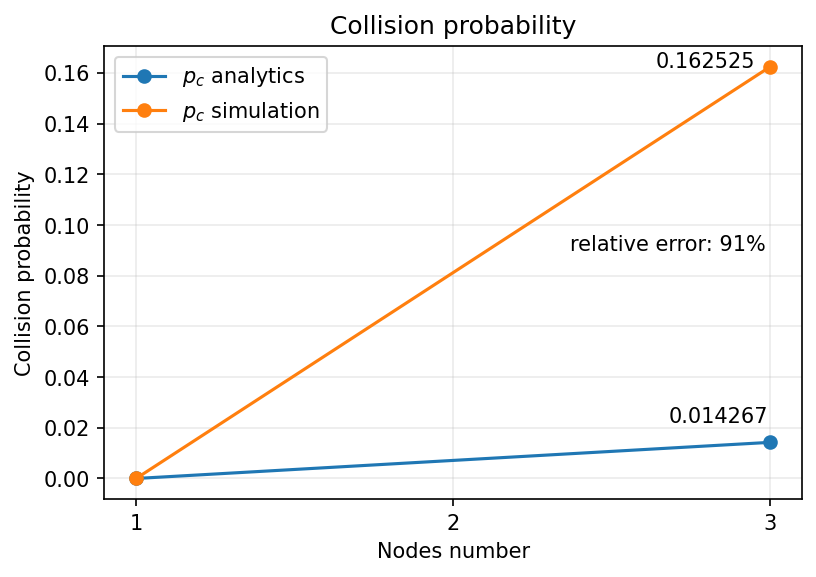

In [16]:
plt.figure(dpi=150)
plt.plot([1, 3], [0, p], label='$p_c$ analytics', marker='o')
plt.plot([1, 3], [0, sim_p], label='$p_c$ simulation', marker='o')
plt.text(2.37, 0.09, f"relative error: {int(np.fabs(p - sim_p) / sim_p * 100)}%")
plt.text(2.68, 0.022, str(round(p, 6)))
plt.text(2.64, 0.162, str(round(sim_p, 6)))
plt.xlabel("Nodes number")
plt.xticks([1, 2, 3])
plt.ylabel("Collision probability")
plt.title("Collision probability")
plt.legend()
plt.grid(alpha=0.25)
plt.savefig("csma_plot_1.png", dpi=600)
plt.show()

In [26]:
0.1482 / 0.1625

0.9119999999999999

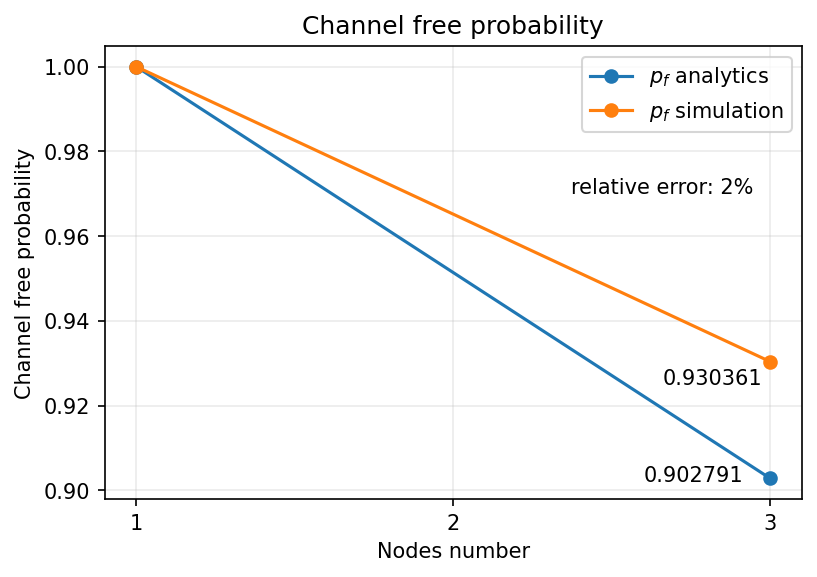

In [17]:
plt.figure(dpi=150)
plt.plot([1, 3], [1, pf], label='$p_f$ analytics', marker='o')
plt.plot([1, 3], [1, sim_pf], label='$p_f$ simulation', marker='o')
plt.text(2.37, 0.97, f"relative error: {int(np.fabs(pf - sim_pf) / sim_pf * 100)}%")
plt.text(2.6, 0.902, str(round(pf, 6)))
plt.text(2.66, 0.925, str(round(sim_pf, 6)))
plt.xlabel("Nodes number")
plt.xticks([1, 2, 3])
plt.ylabel("Channel free probability")
plt.title("Channel free probability")
plt.legend()
plt.grid(alpha=0.25)
plt.savefig("csma_plot_2.png", dpi=600)
plt.show()

In [18]:
test_p_collision(sim_p, sim_pf)

0.01045517168088047

In [19]:
test_p_free(0.00001, 0.99999)

0.8488311800085028

In [20]:
def test_some(p, p_f):
    p_idle = csma_pi_idle(p, p_f)
    p_bo = csma_pi_bo(p, p_f)
    p_rts = csma_pi_rts(p, p_f)
    p_cts = csma_pi_cts(p, p_f)
    p_out = csma_pi_out(p, p_f)
    stat = {
        'B-R-R': p_bo * (p_rts / (p_idle + p_bo + p_rts + p_cts + p_out)) * (p_rts / (p_bo + p_rts + p_cts)), 
        'R-B-R': p_rts * (p_bo / (p_bo + p_rts + p_cts + p_out)) * (p_rts / (p_bo + p_rts + p_cts)), 
        'R-R-B': p_rts * (p_rts / (p_bo + p_rts + p_cts + p_out)) * (p_bo / (p_bo + p_rts + p_cts)), 
        'R-R-R': p_rts * (p_rts / (p_bo + p_rts + p_cts + p_out)) * (p_rts / (p_bo + p_rts + p_cts)), 
        'R-R-C': p_rts * (p_rts / (p_bo + p_rts + p_cts + p_out)) * (p_cts / (p_bo + p_rts + p_cts)), 
        'R-C-R': p_rts * (p_cts / (p_bo + p_rts + p_cts + p_out)) * (p_rts / (p_bo + p_rts)), 
        'C-R-R': p_cts * (p_rts / (p_bo + p_rts + p_out)) * (p_rts / (p_bo + p_rts)), 
        'B-R-C': p_bo * (p_rts / (p_idle + p_bo + p_rts + p_cts + p_out)) * (p_cts / (p_bo + p_rts + p_cts)), 
        'B-C-R': p_bo * (p_cts / (p_idle + p_bo + p_rts + p_cts + p_out)) * (p_rts / (p_bo + p_rts)), 
        'R-B-C': p_rts * (p_bo / (p_bo + p_rts + p_cts + p_out)) * (p_cts / (p_bo + p_rts + p_cts)), 
        'R-C-B': p_rts * (p_cts / (p_bo + p_rts + p_cts + p_out)) * (p_bo / (p_bo + p_rts)), 
        'C-R-B': p_cts * (p_rts / (p_bo + p_rts + p_out)) * (p_bo / (p_bo + p_rts)), 
        'C-B-R': p_cts * (p_bo / (p_bo + p_rts + p_out)) * (p_rts / (p_bo + p_rts))
    }
    return stat

In [21]:
print(sim_p, sim_pf)
st = test_some(sim_p, sim_pf)
for k in st.keys():
    print(f"Case {k}:\tsim: {sim_stats[k]}, \tan: {st[k]}")
# print("metric:    \t", sim_stats['C-B-R'], )

0.16252480288468418 0.9303605573828384
Case B-R-R:	sim: 0.0012836, 	an: 0.001220735557235682
Case R-B-R:	sim: 0.0012825333333333334, 	an: 0.0012626855485197738
Case R-R-B:	sim: 0.001289733333333333, 	an: 0.0012626855485197738
Case R-R-R:	sim: 7.193333333333334e-05, 	an: 5.690995366304964e-05
Case R-R-C:	sim: 7.473333333333334e-05, 	an: 4.766067466178599e-05
Case R-C-R:	sim: 7.766666666666667e-05, 	an: 4.9382065728562976e-05
Case C-R-R:	sim: 7.486666666666668e-05, 	an: 5.1138178557264695e-05
Case B-R-C:	sim: 0.0012479333333333335, 	an: 0.0010223357514216277
Case B-C-R:	sim: 0.0012493333333333332, 	an: 0.0010592601055612256
Case R-B-C:	sim: 0.0012436, 	an: 0.0010574678286412583
Case R-C-B:	sim: 0.0012427999999999999, 	an: 0.0010956610704815095
Case C-R-B:	sim: 0.001254533333333333, 	an: 0.0011346246989444783
Case C-B-R:	sim: 0.0012676666666666663, 	an: 0.0011346246989444783


In [22]:
sim_sum = 0
for k in st.keys():
    sim_sum += sim_stats[k]
sim_sum

0.011660933333333335

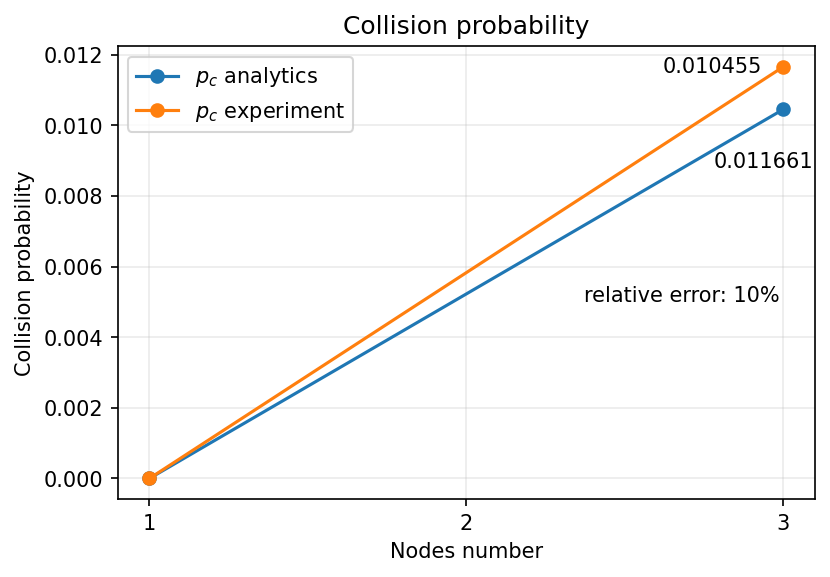

In [23]:
plt.figure(dpi=150)
ptt = test_p_collision(sim_p, sim_pf)
plt.plot([1, 3], [0, ptt], label='$p_c$ analytics', marker='o')
plt.plot([1, 3], [0, sim_sum], label='$p_c$ experiment', marker='o')
plt.text(2.37, 0.005, f"relative error: {int(np.fabs(ptt - sim_sum) / sim_sum * 100)}%")
plt.text(2.62, 0.0115, str(round(ptt, 6)))
plt.text(2.78, 0.0088, str(round(sim_sum, 6)))
plt.xlabel("Nodes number")
plt.xticks([1, 2, 3])
plt.ylabel("Collision probability")
plt.title("Collision probability")
plt.legend()
plt.grid(alpha=0.25)
plt.savefig("csma_plot_3.png", dpi=600)
plt.show()

In [27]:
sim_p_channel = sim_stats['p_coll_channel']
print(sim_p_channel)

0.011732333333333334


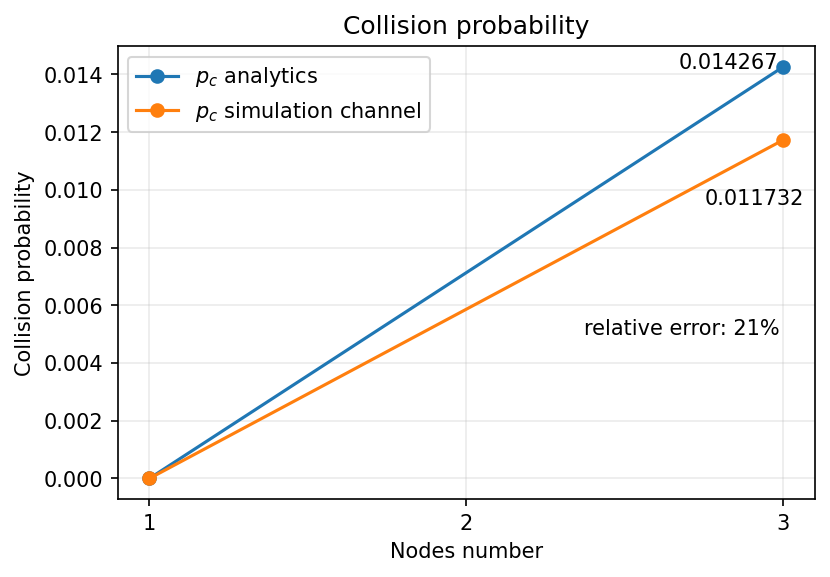

In [42]:
plt.figure(dpi=150)
plt.plot([1, 3], [0, p], label='$p_c$ analytics', marker='o')
plt.plot([1, 3], [0, sim_p_channel], label='$p_c$ simulation channel', marker='o')
plt.text(2.37, 0.005, f"relative error: {int(np.fabs(p - sim_p_channel) / sim_p_channel * 100)}%")
plt.text(2.67, 0.0142, str(round(p, 6)))
plt.text(2.75, 0.0095, str(round(sim_p_channel, 6)))
plt.xlabel("Nodes number")
plt.xticks([1, 2, 3])
plt.ylabel("Collision probability")
plt.title("Collision probability")
plt.legend()
plt.grid(alpha=0.25)
plt.savefig("csma_plot_4.png", dpi=600)
plt.show()